# Colour constancy

In [1]:
import cv2
import os
from classes import WBsRGB as wb_srgb
from evaluation.get_metadata import get_metadata
from evaluation.evaluate_cc import evaluate_cc
import numpy as np
import matplotlib.pyplot as plt

## Function definition

In [2]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

## Settings

In [3]:
in_dir ='../example_images/'  # Directory path
num_images = 10  # Number of images to be corrected
upgraded_model = 1  # Use 1 to load our new model that is upgraded with new training examples.
gamut_mapping = 2  # Use 1 for scaling, 2 for clipping (our paper's results reported using clipping). If the image is over-saturated, scaling is recommended.

## Processing

In [4]:
imgfiles = []
valid_images = (".jpg", ".jpeg", ".png")
for f in os.listdir(in_dir):
    if f.lower().endswith(valid_images):
        imgfiles.append(os.path.join(in_dir, f))
        
imgfiles = np.random.permutation(imgfiles)[:np.minimum(num_images, len(imgfiles))]

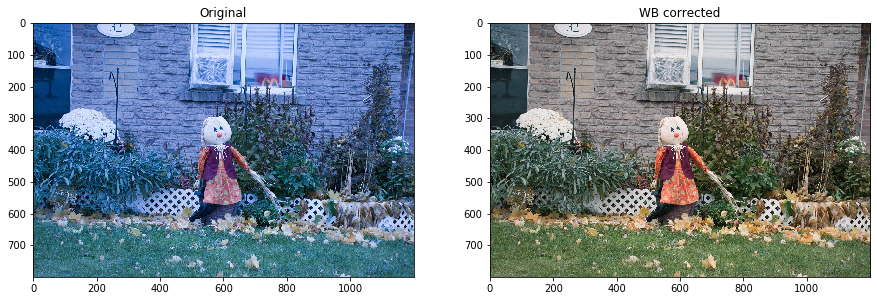

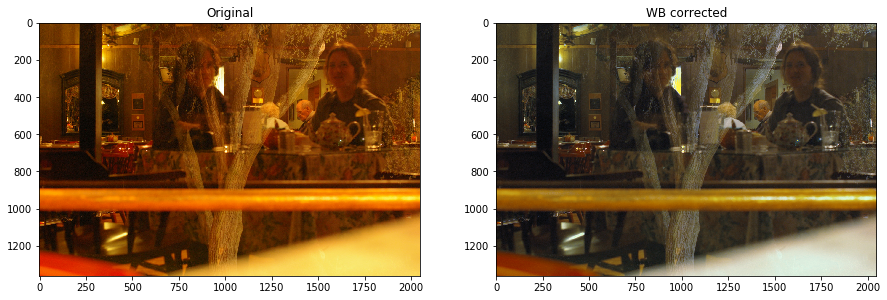

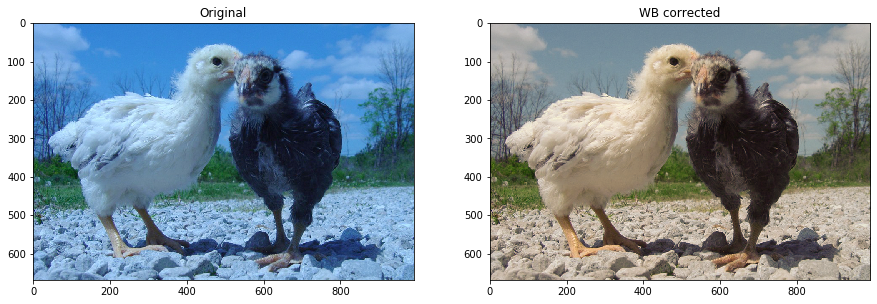

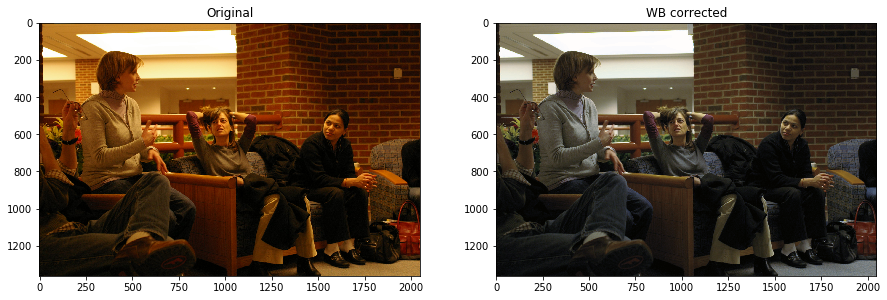

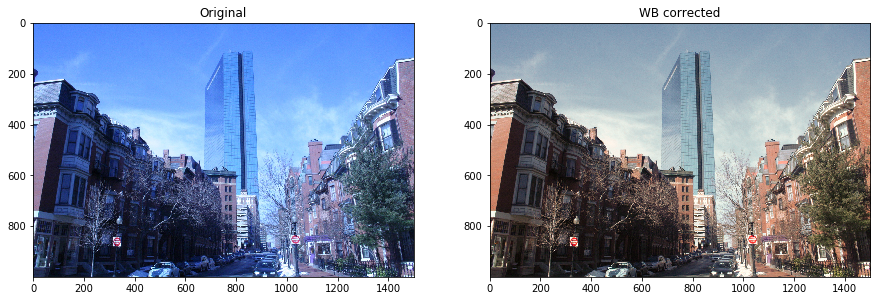

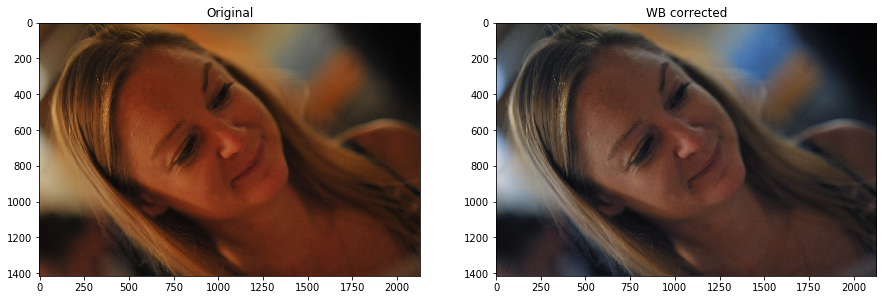

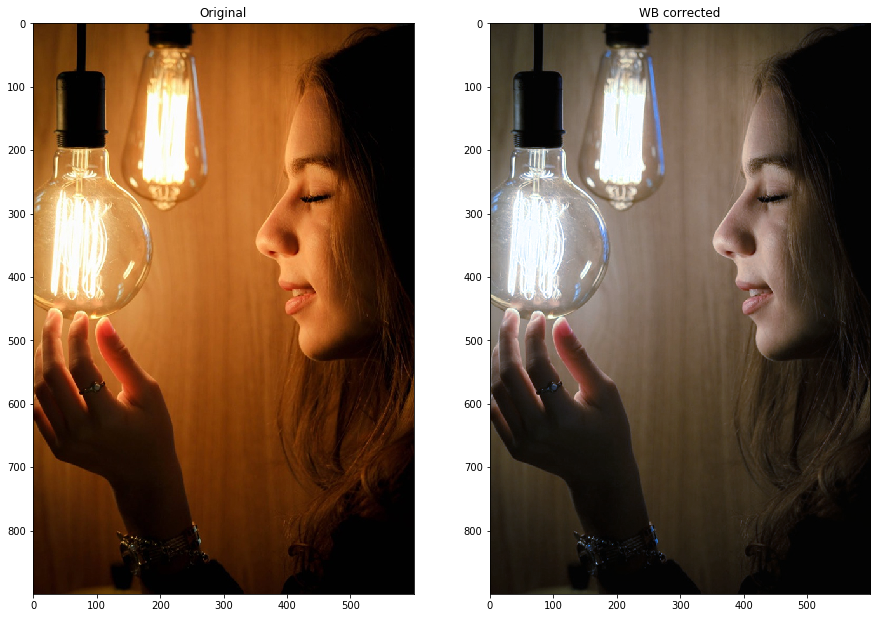

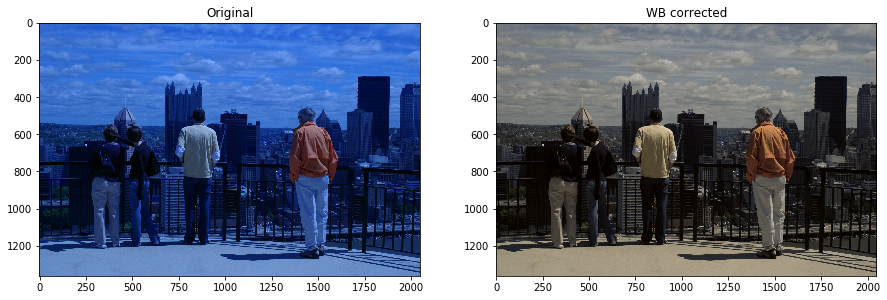

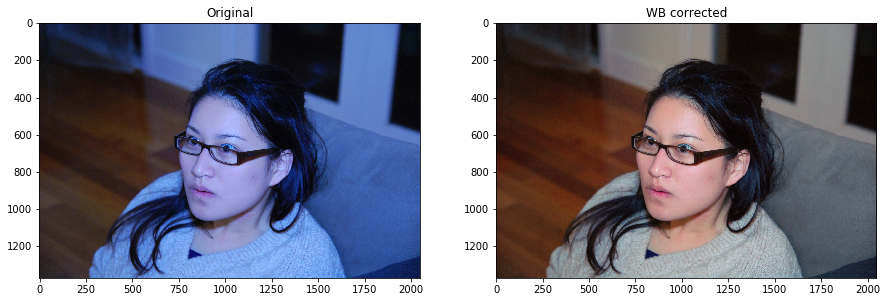

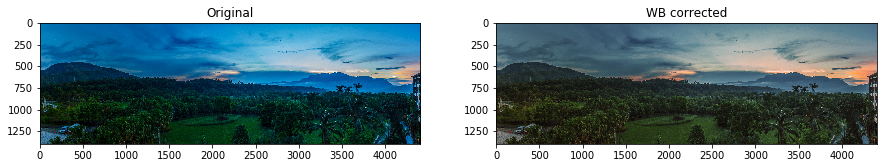

In [5]:
wbModel = wb_srgb.WBsRGB(gamut_mapping=gamut_mapping, upgraded=upgraded_model)

for in_img in imgfiles:
    I = cv2.imread(in_img)  # Read the image
    outImg = wbModel.correctImage(I)  # White balance it
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(outImg, cv2.COLOR_BGR2RGB))
    plt.title('WB corrected')

## Evaluation

In [6]:
dataset_name = 'RenderedWB_Set1'
imgin = 'Canon1DsMkIII_0087_F_P.png'
in_base = os.path.join('..', 'examples_from_datasets', 'RenderedWB_Set1', 'input')
gt_base = os.path.join('..', 'examples_from_datasets', 'RenderedWB_Set1', 'groundtruth')
metadata_base = os.path.join('..', 'examples_from_datasets', 'RenderedWB_Set1', 'metadata')

metadata = get_metadata(imgin, dataset_name, metadata_base)  # Get metadata
cc_mask = np.round(metadata["cc_mask"]).astype("uint64")  # Round any float to nearest integer
I_in = cv2.imread(os.path.join(in_base, imgin), cv2.IMREAD_COLOR)  # Read the image
gt = cv2.imread(os.path.join(gt_base, metadata["gt_filename"]), cv2.IMREAD_COLOR)  # Read ground truth image

# Hide the color chart from both images before processing and evaluation
I_in[cc_mask[1]:cc_mask[1]+cc_mask[3], cc_mask[0]:cc_mask[0]+cc_mask[2],:] = 0
gt[cc_mask[1]:cc_mask[1]+cc_mask[3], cc_mask[0]:cc_mask[0]+cc_mask[2],:] = 0

DeltaE 2000: 2.81, MSE= 31.22, MAE= 3.30, DeltaE 76= 3.71



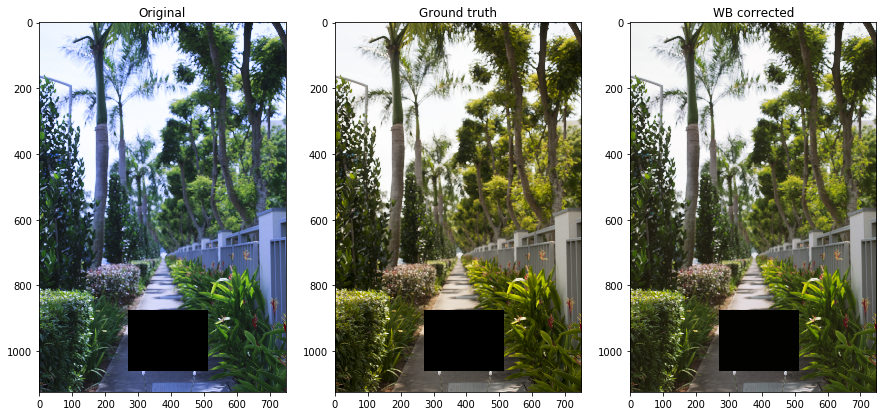

In [7]:
# Processing
I_corr = wbModel.correctImage(I_in)  # White balanced I_in
I_corr = (I_corr * 255).astype('uint8')

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(cv2.cvtColor(I_in, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.subplot(132)
plt.imshow(cv2.cvtColor(gt, cv2.COLOR_BGR2RGB))
plt.title('Ground truth')
plt.subplot(133)
plt.imshow(cv2.cvtColor(I_corr, cv2.COLOR_BGR2RGB))
plt.title('WB corrected')

# Evaluation
deltaE00, MSE, MAE, deltaE76 = evaluate_cc(I_corr, gt, metadata["cc_mask_area"], opt=4)
print('DeltaE 2000: %0.2f, MSE= %0.2f, MAE= %0.2f, DeltaE 76= %0.2f\n' %(deltaE00, MSE, MAE, deltaE76))